In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import os
import cv2
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive

In [2]:
# Configurações
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 10
LEARNING_RATE = 0.0001

In [3]:
# Classes dos bombons
CLASSES = ['alpino', 'amor_carioca', 'charge', 'chokito', 'galak',
           'lollo', 'negresco', 'prestigio', 'sensacao', 'smash']

print(f"Classes identificadas: {CLASSES}")
print(f"Número de classes: {len(CLASSES)}")

Classes identificadas: ['alpino', 'amor_carioca', 'charge', 'chokito', 'galak', 'lollo', 'negresco', 'prestigio', 'sensacao', 'smash']
Número de classes: 10


In [4]:
# Função para carregar e preprocessar imagens (com data augmentation)
def load_and_preprocess_data(data_dir, apply_augmentation=True):
    """
    Carrega imagens e labels do diretório com data augmentation
    """
    images = []
    labels = []

    # Data augmentation
    if apply_augmentation:
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )

    for class_idx, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_files = glob(os.path.join(class_path, '*.png'))
            print(f"Classe {class_name}: {len(image_files)} imagens")

            for img_path in image_files:
                # Carrega e redimensiona imagem
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                img = img.astype('float32') / 255.0  # Normalização

                images.append(img)
                labels.append(class_idx)

    return np.array(images), np.array(labels)

In [5]:
# Função para criar o modelo CNN
def create_cnn_model():
    """
    Cria uma CNN mais simples para evitar overfitting
    """
    model = keras.Sequential([
        # Primeira camada convolucional
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Segunda camada convolucional
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Terceira camada convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Camadas densas
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [6]:
# Função alternativa: Transfer Learning
def create_transfer_learning_model():
    """
    Usa transfer learning com MobileNetV2 para melhor performance
    """
    # Base pre-treinada
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Congela as camadas base
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [7]:
# Função para plotar histórico de treinamento
def plot_training_history(history):
    """
    Plota curvas de loss e acurácia
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Acurácia
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [8]:
# Função para plotar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão - CNN')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    return cm

In [9]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    """
    Calcula acurácia e F1-score
    """
    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, f1

In [10]:
def plot_overall_roc_curve(y_true, y_pred_proba):
    """
    Plota a curva ROC micro‑average (ROC do modelo geral).
    """
    # Binariza as labels verdadeiras
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)

    # Calcula micro-average ROC
    # Flatten para considerar todas as classes juntas
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Micro‑average ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Classificador aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC Geral do Modelo')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def predict_on_folder(model, folder_path, img_size=IMG_SIZE, class_names=CLASSES):
    """
    Carrega todas as imagens .png de folder_path, faz a predição
    usando 'model' e imprime para cada imagem o nome previsto.
    Retorna uma lista de tuplas (img_path, classe_prevista).
    """
    results = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        for img_path in glob(os.path.join(folder_path, ext)):
            # Carrega e preprocessa igual ao treino
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            img_array = np.expand_dims(img, axis=0)  # batch de tamanho 1

            # Predição
            proba = model.predict(img_array)
            idx = np.argmax(proba, axis=1)[0]
            label = class_names[idx]
            results.append((img_path, label))

            print(f"{os.path.basename(img_path)} → {label}")
    return results

In [12]:
# Carregar dados e logar no drive
drive.mount('/content/drive')
print("Carregando dados...")
data_dir = "/content/drive/MyDrive/Notebooks PDI/dataset_aug"
X, y = load_and_preprocess_data(data_dir)

print(f"Total de imagens: {len(X)}")
print(f"Shape das imagens: {X.shape}")

Mounted at /content/drive
Carregando dados...
Classe alpino: 112 imagens
Classe amor_carioca: 112 imagens
Classe charge: 112 imagens
Classe chokito: 112 imagens
Classe galak: 112 imagens
Classe lollo: 112 imagens
Classe negresco: 112 imagens
Classe prestigio: 112 imagens
Classe sensacao: 112 imagens
Classe smash: 112 imagens
Total de imagens: 1120
Shape das imagens: (1120, 224, 224, 3)


In [13]:
# Dividir dados (80% treino, 10% validação, 10% teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Treino: {len(X_train)} imagens")
print(f"Validação: {len(X_val)} imagens")
print(f"Teste: {len(X_test)} imagens")

Treino: 896 imagens
Validação: 112 imagens
Teste: 112 imagens


In [14]:
# Criar modelo
print("\nCriando modelo CNN...")

# OPÇÃO 1: CNN simples (recomendado para poucos dados)
model = create_cnn_model()

model.summary()


Criando modelo CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,562,794 (21.22 MB)

 Trainable params: 5,562,794 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compilar modelo
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.3, patience=3, min_lr=1e-8, monitor='val_loss'
    )
]

In [17]:
# Treinamento
print("\nIniciando treinamento...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Iniciando treinamento...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.0919 - loss: 2.4914 - val_accuracy: 0.1339 - val_loss: 2.2955 - learning_rate: 1.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 913ms/step - accuracy: 0.1310 - loss: 2.3003 - val_accuracy: 0.1429 - val_loss: 2.2956 - learning_rate: 1.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 867ms/step - accuracy: 0.1397 - loss: 2.2943 - val_accuracy: 0.1161 - val_loss: 2.2941 - learning_rate: 1.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 858ms/step - accuracy: 0.1500 - loss: 2.2751 - val_accuracy: 0.1786 - val_loss: 2.2851 - learning_rate: 1.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 848ms/step - accuracy: 0.1558 - loss: 2.2599 - val_accuracy: 0.1429 - val_loss: 2.2666 - learning_rate: 1.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 825ms/step - accuracy: 0.2083 - loss: 2.2125 - val_accuracy: 0.3304 - val_loss: 2.1983 - learning_rate: 1.0000e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━

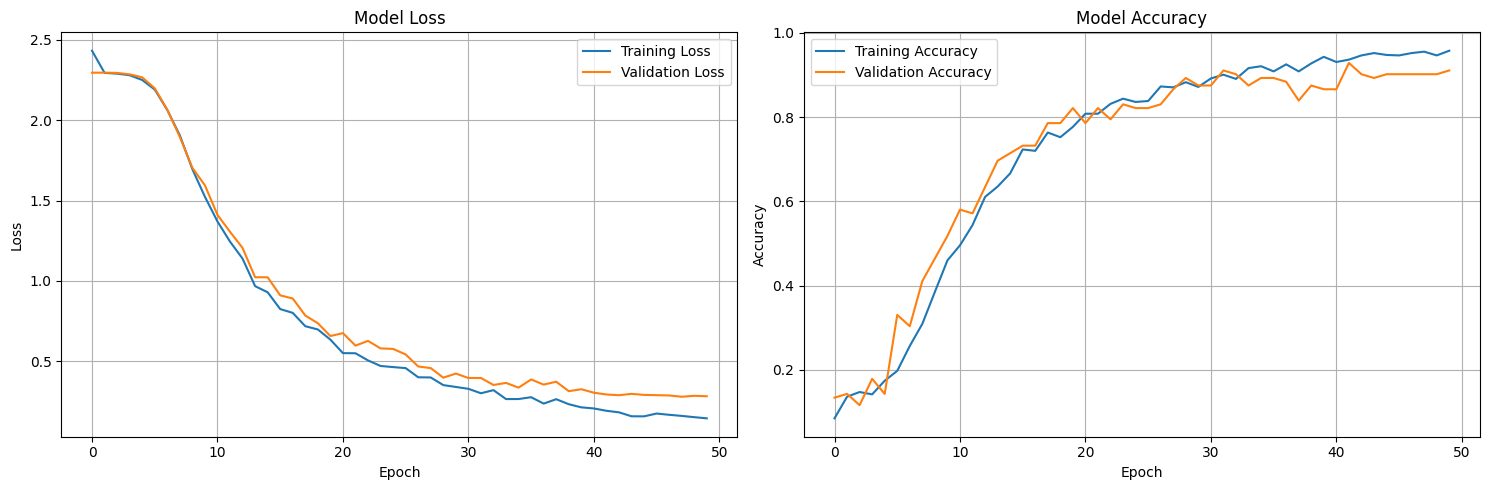

In [18]:
# Plotar histórico
plot_training_history(history)

In [19]:
 # Avaliação no conjunto de teste
print("\nAvaliando modelo no conjunto de teste...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no teste: {test_accuracy:.4f}")


Avaliando modelo no conjunto de teste...
Acurácia no teste: 0.8393


In [20]:
# Predições
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step


In [21]:
# Métricas
accuracy, f1 = calculate_metrics(y_test, y_pred)

Acurácia: 0.8393
F1-Score: 0.8342


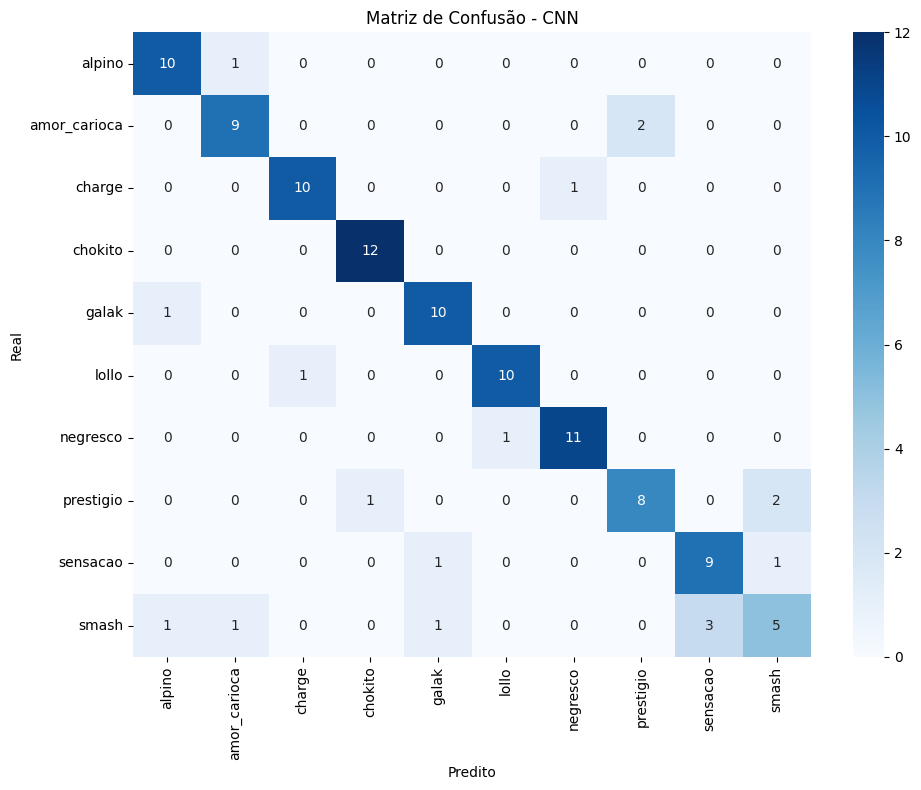

In [22]:
# Matriz de confusão
cm = plot_confusion_matrix(y_test, y_pred, CLASSES)

In [23]:
# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=CLASSES))


Relatório de Classificação:
              precision    recall  f1-score   support

      alpino       0.83      0.91      0.87        11
amor_carioca       0.82      0.82      0.82        11
      charge       0.91      0.91      0.91        11
     chokito       0.92      1.00      0.96        12
       galak       0.83      0.91      0.87        11
       lollo       0.91      0.91      0.91        11
    negresco       0.92      0.92      0.92        12
   prestigio       0.80      0.73      0.76        11
    sensacao       0.75      0.82      0.78        11
       smash       0.62      0.45      0.53        11

    accuracy                           0.84       112
   macro avg       0.83      0.84      0.83       112
weighted avg       0.83      0.84      0.83       112



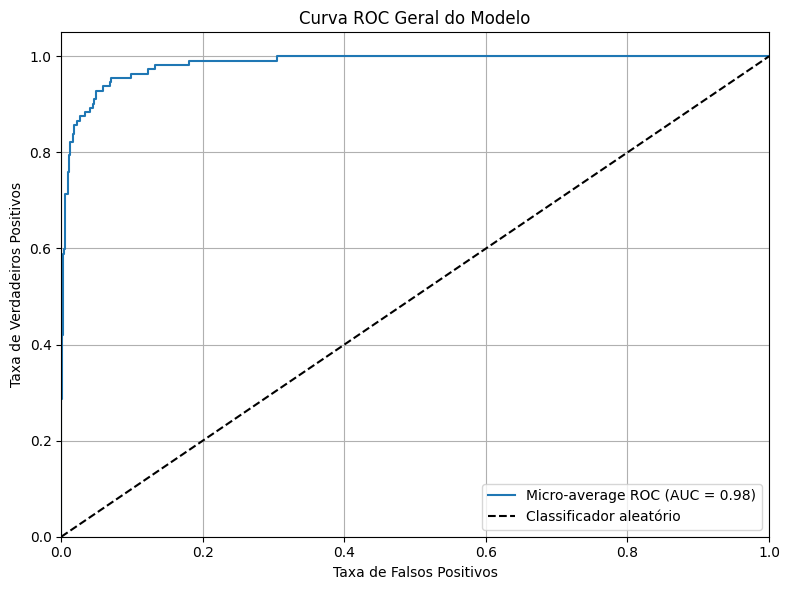

In [24]:
# Curva ROC
plot_overall_roc_curve(y_test, y_pred_proba)

In [25]:
# Salvar modelo
model.save('/content/drive/MyDrive/cnn_bombons_model.keras')
print("\nModelo salvo!")


Modelo salvo!


In [26]:
# Predição em um diretório externo de teste
test_folder = "/content/drive/MyDrive/Notebooks PDI/dataset_teste/"
print(f"\nPredizendo imagens em: {test_folder}")
predict_on_folder(model, test_folder)


Predizendo imagens em: /content/drive/MyDrive/Notebooks PDI/dataset_teste/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
alpinoBranco.png → galak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
galakBranco.png → galak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
chokitoBranco.png → smash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
chargeBranco.png → charge
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
lolloBranco.png → lollo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
negrescoBranco.png → negresco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
smashBranco.png → smash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
amorcariocaBranco.png → amor_carioca


[('/content/drive/MyDrive/Notebooks PDI/dataset_teste/alpinoBranco.png',
  'galak'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/galakBranco.png',
  'galak'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/chokitoBranco.png',
  'smash'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/chargeBranco.png',
  'charge'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/lolloBranco.png',
  'lollo'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/negrescoBranco.png',
  'negresco'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/smashBranco.png',
  'smash'),
 ('/content/drive/MyDrive/Notebooks PDI/dataset_teste/amorcariocaBranco.png',
  'amor_carioca')]